# PPCA in PyStan

In this notebook, we try to perform a PPCA in Pystan.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

Here, the model is defined in Stan.

In [2]:
latent = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    for (d in 1:D)
        W[d] ~ normal(0.0,sigma);
    sigma~lognormal(0.0, 1.0) ;
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_pystan = pystan.StanModel(model_code=latent)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8f34402276fb5cc67587951916679ef NOW.


We specify our parameters and generate some data.

In [3]:
N=5000
M=2
D=3
z = np.random.normal(0,1, size=(N,M))
sigma = np.random.lognormal(0,1)
W = np.random.normal(0,sigma,size=(M,D))
x = np.random.normal(np.matmul(z,W),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x}

And then we can optimize our parameters and latent dataset.

In [4]:
op = ppca_pystan.optimizing(data=ppca_dat)

z_sim = op['z'].T
sigma_sim = op['sigma']
W_sim = op['W'].T
x_sim = np.random.normal(np.matmul(z_sim,W_sim),sigma_sim)

Let's compare our models with the real values and the values as found by Tipping & Bishops PPCA method.

In [5]:
ppca = PPCA()
ppca.fit(x)
_, sigma_ppca, W_ppca = ppca.parameters()
# ppca_em = PPCA()
# ppca_em.fit(x, form='em', em_calc_loglikelihood=False)
# _, sigma_ppca_em, W_ppca_em = ppca.parameters()

In [6]:
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance: ', sigma_sim*2)
print()
print('real z: ', z)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W: ', W_sim)
print()

real variance:  0.5003169000266546
PPCA variance:  0.4842355065555636
simulated variance:  0.8173022597518063

real z:  [[-0.02777869  1.26062714]
 [ 0.52122578 -0.49706486]
 [-1.20356926 -0.47421757]
 ...
 [-0.00839614  0.79998635]
 [-1.34321087 -0.28237403]
 [-0.51619781 -0.39158578]]
simulated z:  [[ 0.3670602  -0.0381571 ]
 [-0.09587581  0.13241224]
 [-0.16507718 -0.31481775]
 ...
 [ 0.15362601 -0.06986124]
 [-0.19259897 -0.18296213]
 [-0.24608222  0.14457039]]

real W:  [[ 0.49613827  0.2587615   0.77770299]
 [ 0.5532477   1.59113626 -0.03210531]]
PPCA W:  [[-0.67090727 -0.10921962]
 [-1.44550933  0.38712494]
 [ 0.65759954  0.73953287]]
simulated W:  [[ 3.1025875   6.39631192  1.58997497]
 [ 1.74430138 -2.47355685  4.75398699]]



Since $W$ can be rotated, we will compare the shapes of $W$ with the estimate of $W$ and the PPCA solution.

In [7]:
print('Original W and Simulated W:')
rotation_check(W.T,W_sim.T, verbose=True)
rotation_check(W.T,W_sim.T, verbose=True, method='angles')
print()
print('Original W and PPCA W:')
rotation_check(W.T,W_ppca, verbose=True)
rotation_check(W.T,W_ppca, verbose=True, method='angles')
print()
print('PPCA W and simulated W:')
rotation_check(W_ppca,W_sim.T, verbose=True)
rotation_check(W_ppca,W_sim.T, verbose=True, method='angles')

Original W and Simulated W:
These might not be rotations. det(R)= -27.802887207104206 R.T*R=
 [[18.20172434  4.1058354 ]
 [ 4.1058354  43.39470298]]
These matrices differ in magnitude on row 2 as they are of length 0.552 and 12.669 (0.044x).
These matrices differ in magnitude on row 2 as they are of length 0.606 and 25.128 (0.024x).
These matrices differ in magnitude on row 2 as they are of length 2.599 and 47.031 (0.055x).
These matrices differ at least on the angle between axis 0 and 1 as they are 0.570 and 0.736.
These matrices are approximately equal on the angle between axis 0 and 2 as they are 0.881 and 0.881.
These matrices differ at least on the angle between axis 1 and 2 as they are 1.451 and 1.617.

Original W and PPCA W:
These might not be rotations. det(R)= 0.7231736557666573 R.T*R=
 [[1.48562585 0.32921884]
 [0.32921884 0.42498263]]
These matrices differ in magnitude on row 2 as they are of length 0.552 and 0.462 (1.195x).
These matrices differ in magnitude on row 2 as the

../Python/rotation_check.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if method=='find_rotation_mat':


False

It looks like the PPCA solutions are identical (as expected), but not entirely equal to the real solution. The PyStan solution differs even more from the original $W$. One consistent difference is that the values of the simulated $W$ are significantly larger.

The result is plotted below. Similarly to what happened in TensorFlow Probability, the observed data $x$ is predicted accurately, but the latent data $z$ has smaller values, in accordance with the higher values of the solution for $W$. The value for $\sigma$ is also off.

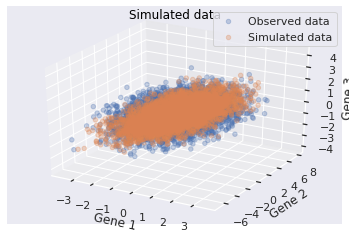

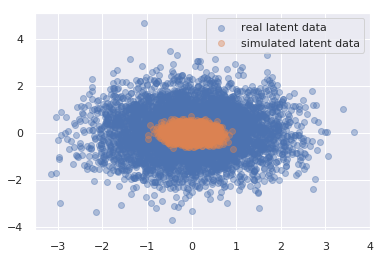

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim[:,0],x_sim[:,1],x_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[:,0], z[:,1], label='real latent data', alpha=0.4)
plt.scatter(z_sim[:,0], z_sim[:,1], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()

We can also try to add a $\mu$ to the $x$ values:

In [9]:
latent_mu = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    for (d in 1:D){
        W[d] ~ normal(0.0,sigma);
        mu[d]~normal(0.0, 5.0) ;
        }
    sigma~lognormal(0.0, 1.0) ;
    
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n)+mu, sigma);
}
"""
ppca_pystan_mu = pystan.StanModel(model_code=latent_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be233f9d9d0bebbf3ffe0592c0372481 NOW.


In [10]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(N,M))
sigma = np.random.lognormal(0,1)
mu = np.random.normal(0,5,size=D)
W = np.random.normal(0,sigma,size=(M,D))
x = np.random.normal(np.matmul(z,W)+mu,sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x}

In [11]:
op = ppca_pystan_mu.optimizing(data=ppca_dat)

z_sim = op['z'].T
sigma_sim = op['sigma']
W_sim = op['W'].T
mu_sim = op['mu'].T
x_sim = np.random.normal(np.matmul(z_sim,W_sim)+mu,sigma_sim)

In [12]:
ppca = PPCA()
ppca.fit(x)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
# ppca_em = PPCA()
# ppca_em.fit(x, form='em', em_calc_loglikelihood=False)
# mu_ppca_em, sigma_ppca_em, W_ppca_em = ppca.parameters()

In [13]:
print('real mu: ', mu)
print('PPCA mu: ', mu_ppca)
# print('PPCA mu (em): ', mu_ppca_em)
print('simulated mu: ', mu_sim)
print()
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)
print('simulated variance: ', sigma_sim*2)
print()
print('real z: ', z)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W: ', W_sim)
print()

real mu:  [ 6.11221814 -0.53658712  2.13723413]
PPCA mu:  [[ 6.10465318]
 [-0.53230087]
 [ 2.14747199]]
simulated mu:  [ 6.10705354 -0.53518416  2.14615092]

real variance:  0.10630585949779318
PPCA variance:  0.10214808206140231
simulated variance:  0.37955452856534183

real z:  [[-0.30335621 -0.77832285]
 [ 0.8133585  -1.5297087 ]
 [-1.43074345  1.73533147]
 ...
 [ 0.30391464  0.70685667]
 [-0.25228133 -1.4633914 ]
 [-1.29124505  0.71804721]]
simulated z:  [[-0.28614507 -0.26959385]
 [-0.66262641  0.01889584]
 [ 0.20588173 -0.44419427]
 ...
 [ 0.05107102  0.07249831]
 [-0.19494132 -0.20009848]
 [ 0.22596287 -0.41690725]]

real W:  [[ 0.37547485 -0.37456299  0.02801216]
 [ 0.02225845  0.062994    0.2978457 ]]
PPCA W:  [[ 0.36128758  0.00549772]
 [-0.3516072   0.06884382]
 [ 0.07934399  0.28004295]]
simulated W:  [[ 0.1421853   0.39473073  1.54151132]
 [ 1.35365245 -1.30769857  0.15786933]]



In [14]:
print('Original W and Simulated W:')
rotation_check(W.T,W_sim.T, verbose=True)
rotation_check(W.T,W_sim.T, verbose=True, method='angles')
print()
print('Original W and PPCA W:')
rotation_check(W.T,W_ppca, verbose=True)
rotation_check(W.T,W_ppca, verbose=True, method='angles')
print()
print('PPCA W and simulated W:')
rotation_check(W_ppca,W_sim.T, verbose=True)
rotation_check(W_ppca,W_sim.T, verbose=True, method='angles')

Original W and Simulated W:
These might not be rotations. det(R)= -18.606163428669436 R.T*R=
 [[27.29757146  0.8902626 ]
 [ 0.8902626  12.7110899 ]]
These matrices differ in magnitude on row 2 as they are of length 0.089 and 1.853 (0.048x).
These matrices differ in magnitude on row 2 as they are of length 0.141 and 1.866 (0.076x).
These matrices differ in magnitude on row 2 as they are of length 0.144 and 2.401 (0.060x).
These matrices are approximately equal on the angle between axis 0 and 1 as they are 1.418 and 1.364.
These matrices are approximately equal on the angle between axis 0 and 2 as they are 1.498 and 1.380.
These matrices are approximately equal on the angle between axis 1 and 2 as they are 2.916 and 2.744.

Original W and PPCA W:
These might not be rotations. det(R)= 0.9086903157549242 R.T*R=
 [[0.95154672 0.13099378]
 [0.13099378 0.88579724]]
These matrices are approximately equal in magnitude on row 2 as they are of length 0.089 and 0.085 (1.056x).
These matrices diffe

False

The result is plotted below. We see that $\mu$ is estimated well, but the other parameters are still off, even though the end result of $x$ looks good.

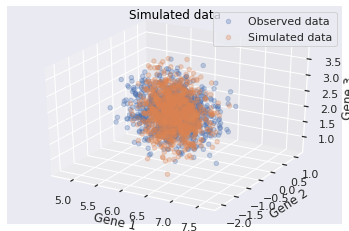

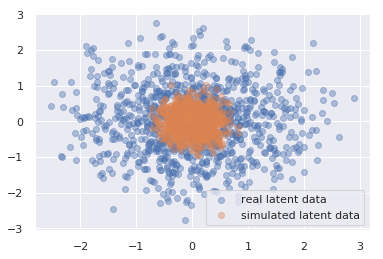

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim[:,0],x_sim[:,1],x_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[:,0], z[:,1], label='real latent data', alpha=0.4)
plt.scatter(z_sim[:,0], z_sim[:,1], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()

In [16]:
print('real W: ', W)
print('simulated W: ', W_sim)
print()
print(np.dot(W[0],W[1])/(np.linalg.norm(W[0],2)*np.linalg.norm(W[1],2)))
print(np.dot(W_sim[0],W_sim[1])/(np.linalg.norm(W_sim[0],2)*np.linalg.norm(W_sim[1],2)))

real W:  [[ 0.37547485 -0.37456299  0.02801216]
 [ 0.02225845  0.062994    0.2978457 ]]
simulated W:  [[ 0.1421853   0.39473073  1.54151132]
 [ 1.35365245 -1.30769857  0.15786933]]

-0.04252787504925286
-0.02663247914022393


In [17]:
print(np.linalg.eig(np.matmul(W.T,W)))
print(np.linalg.eig(np.matmul(W_sim.T,W_sim)))
print(np.linalg.eig(np.matmul(W.T,W))[0]/np.linalg.eig(np.matmul(W_sim.T,W_sim))[0])

(array([ 2.82314796e-01, -9.54097912e-18,  9.29244280e-02]), array([[ 0.70467072, -0.69968085,  0.11783838],
       [-0.70880047, -0.68661347,  0.1617524 ],
       [ 0.03226564,  0.19750608,  0.97977052]]))
(array([-4.44089210e-16,  3.57369592e+00,  2.54596348e+00]), array([[-0.68895618, -0.70795289,  0.15537727],
       [-0.68433998,  0.70599606,  0.18234131],
       [ 0.23878479, -0.01929429,  0.97088081]]))
[-6.35716406e+14 -2.66977922e-18  3.64987278e-02]


## Generating Samples with PyStan

The following section tries to actually generate samples from our distribution. To be honest, PyStan does not lend itself for this feature. I have not found *any* examples of people generating data with PyStan. It is however possible to generate samples from the parameters that are optimized according to the distribution of their posterior probability. The following piece of code treats the output $x$ as a parameter which allows us to sample $x$. It is not a very elegant way to produce samples of the output variable. Besides that, PyStan will try to produce thousands of samples by default - meaning thousands of $\sigma^2$'s, accompanied by a thousand datapoints in $z$ and $x$ for *each* $\sigma^2$ (leading to millions of datapoints). It is possible to write a PyStan model that only outputs $1$ datapoint per run to reduce the number of datapoints, but this will draw a new value for $\sigma^2$ for each datapoint. It is also possible - as performed here in the cells below - to explicitly ask for only one sample of our data ($1$ $\sigma^2$ and $W$, but $1000$ datapoints in $z$ and $x$). Still, this will cause PyStan to generate a lot more samples so that the generating Markov chain has reached a stationary distribution, which is very inefficient computationally.

In [18]:
latent_sampling = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[N,D] x;//  observations
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    sigma~lognormal(0.0, 1.0) ;
    for (d in 1:D)
        W[d] ~ normal(0.0,sigma);
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_sampling = pystan.StanModel(model_code=latent_sampling)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07f0256a61c07190db137f50319d640b NOW.


In [19]:
N=1000
M=2
D=3

samples = ppca_sampling.sampling(data={'N':N,'D':D,'M':M}, iter=100, warmup=99, chains=1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/usr/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


In [20]:
samples.extract()

OrderedDict([('z',
              array([[[-1.4919471 , -0.5308368 , -1.11364885, ...,  2.13207996,
                       -0.76561266,  0.34264069],
                      [ 0.1584962 ,  0.45498674,  0.20079598, ..., -0.61979953,
                       -1.30981476, -0.51506728]]])),
             ('x', array([[[-0.74134841, -0.86861905, -0.83414094],
                      [ 0.56773839, -0.35261791,  0.46332926],
                      [ 0.87004745, -1.95989454, -2.18629759],
                      ...,
                      [ 1.15859866,  1.22213842, -0.10539375],
                      [-1.59871305,  1.21204394, -2.88618461],
                      [ 0.58639993,  0.73970227,  0.12435184]]])),
             ('W', array([[[-0.03036864, -0.01717178],
                      [ 0.53142   , -0.75094403],
                      [ 0.14425788,  0.43111272]]])),
             ('sigma', array([0.87004451])),
             ('lp__', array([-2124.15171847]))])